# Calibration using graphs

In [1]:
%matplotlib inline

import os
import sys

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from functools import partial
from dask import delayed
from distributed import progress
import dask.bag as bag

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from arl.calibration.solvers import solve_gaintable
from arl.calibration.operations import apply_gaintable
from arl.data.data_models import Image
from arl.data.polarisation import PolarisationFrame
from arl.data.parameters import get_parameter
from arl.visibility.base import create_blockvisibility
from arl.skycomponent.operations import create_skycomponent
from arl.image.deconvolution import deconvolve_cube
from arl.image.operations import show_image
from arl.image.gather_scatter import image_gather
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import predict_2d, advise_wide_field
    
from arl.graphs.dask_init import get_dask_Client
from arl.graphs.graphs import create_invert_wstack_graph, create_predict_wstack_graph, \
    create_selfcal_graph_list
from arl.graphs.generic_graphs import create_generic_image_graph
from arl.util.graph_support import create_simulate_vis_graph, \
    create_predict_gleam_model_graph, create_corrupt_vis_graph, \
    create_gleam_model_graph
from arl.pipelines.graphs import create_continuum_imaging_pipeline_graph
from arl.graphs.vis import simple_vis

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
c=get_dask_Client()

Creating Dask Client
<Client: scheduler='tcp://127.0.0.1:62846' processes=8 cores=8>
Diagnostic pages available on port http://127.0.0.1:8787


We create a graph to make the visibility 

In [3]:
nfreqwin=3
ntimes=5
frequency=numpy.linspace(0.8e8,1.2e8,nfreqwin)
if nfreqwin > 1:
    channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
else:
    channel_bandwidth=numpy.array([1e7])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

vis_graph_list=create_simulate_vis_graph('LOWBD2-CORE',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre)

Find the optimum values for wide field imaging

In [4]:
wprojection_planes=1
advice=advise_wide_field(vis_graph_list[0].compute(), guard_band_image=4.0, delA=0.02,
                         wprojection_planes=wprojection_planes)
vis_slices = advice['vis_slices']

advise_wide_field: Maximum wavelength 3.747 (meters)
advise_wide_field: Maximum baseline 210.1 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.107069 (rad) 6.135 (deg)
advise_wide_field: Image field of view 0.428275 (rad) 24.538 (deg)
advise_wide_field: Synthesized beam 0.004759 (rad) 0.273 (deg)
advise_wide_field: Cellsize 0.001586 (rad) 0.091 (deg)
advice_wide_field: Npixels per side = 270
advice_wide_field: W sampling for full image = 0.3 (wavelengths)
advice_wide_field: W sampling for primary beam = 5.6 (wavelengths)
advice_wide_field: Time sampling for full image = 45.4 (s)
advice_wide_field: Time sampling for primary beam = 726.9 (s)
advice_wide_field: Frequency sampling for full image = 42066.2 (Hz)
advice_wide_field: Frequency sampling for primary beam = 673058.5 (Hz)
advice_wide_field: Number of planes in w stack 37
advice_wide_field: Number of planes in w projection 1
advice_wide_field: Recommend 2d gridding


Now make a graph to fill with a model drawn from GLEAM. We then add phase errors of off 1 radian rms to each station. We will compute this graph in order not to confuse it's processing with the imaging. 

In [5]:
corrupted_vis_graph_list = create_predict_gleam_model_graph(vis_graph_list,
                                                                c_predict_graph=create_predict_wstack_graph,
                                                                vis_slices=vis_slices)
corrupted_vis_graph_list = create_corrupt_vis_graph(corrupted_vis_graph_list, 
                                                    phase_error=1.0)
corrupted_vis_graph_list=c.compute(corrupted_vis_graph_list)

Now make a graph to construct the LSM. The LSM is drawn from GLEAM as well but only includes sources brighter than 1 Jy

In [6]:
LSM_graph=create_gleam_model_graph(vis_graph_list[len(vis_graph_list)//2], 
                                   flux_limit=1.0).compute()

Now make a dirty image to see the effect of the phase errors introduced

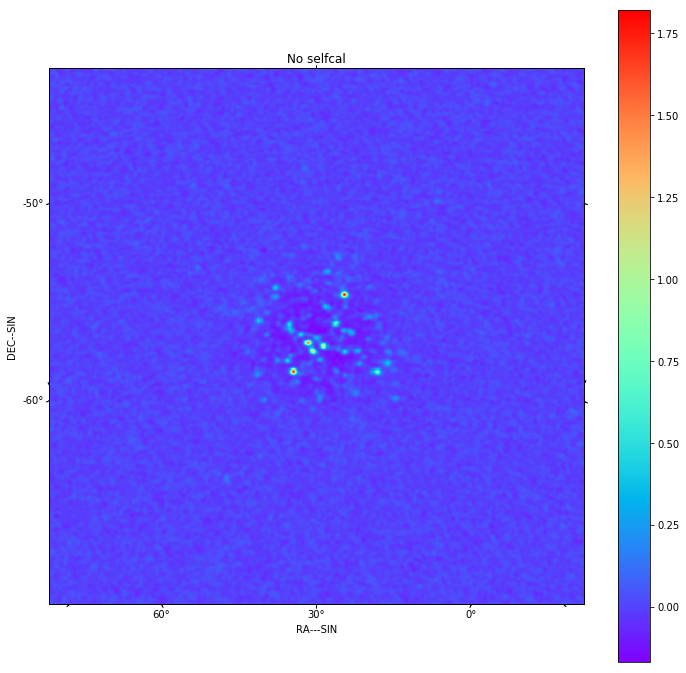

In [7]:
dirty_graph = create_invert_wstack_graph(corrupted_vis_graph_list, LSM_graph,
                                         vis_slices=vis_slices, dopsf=False)
dirty=dirty_graph.compute()
show_image(dirty[0], title='No selfcal')
plt.show()

First make a selfcal graph in which the different Visibility's are selfcal'ed independently. We will look at the graph for just one Visibility.

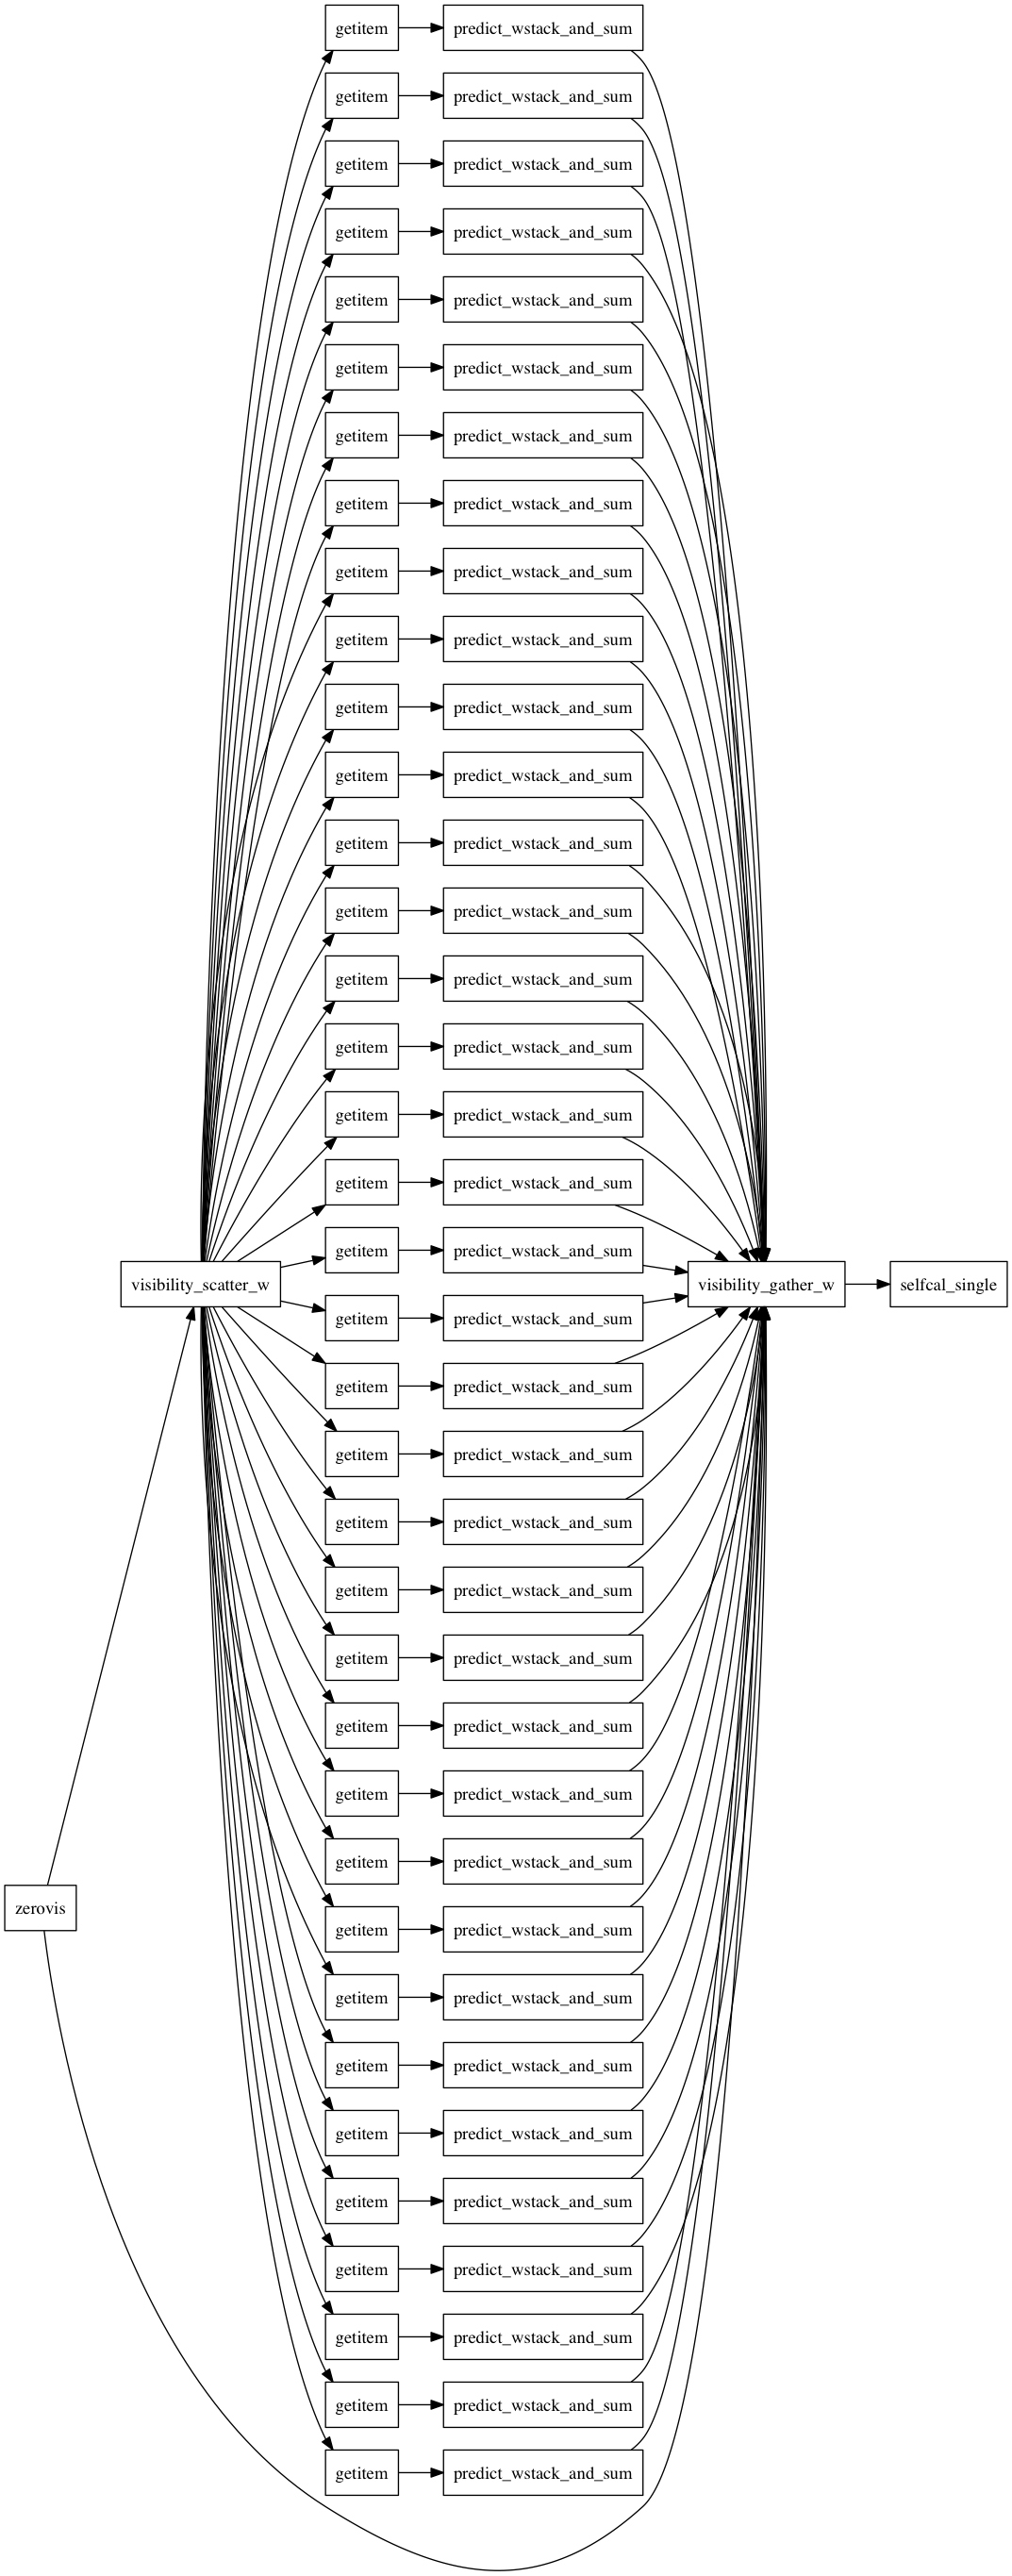

In [8]:
selfcal_vis_graph_list = create_selfcal_graph_list(corrupted_vis_graph_list, LSM_graph,
                                                   c_predict_vis_graph=create_predict_wstack_graph,
                                                   vis_slices=vis_slices,
                                                   global_solution=False)
simple_vis(selfcal_vis_graph_list[0])

Now make a global solution. Note that all Visibilities are now coupled.

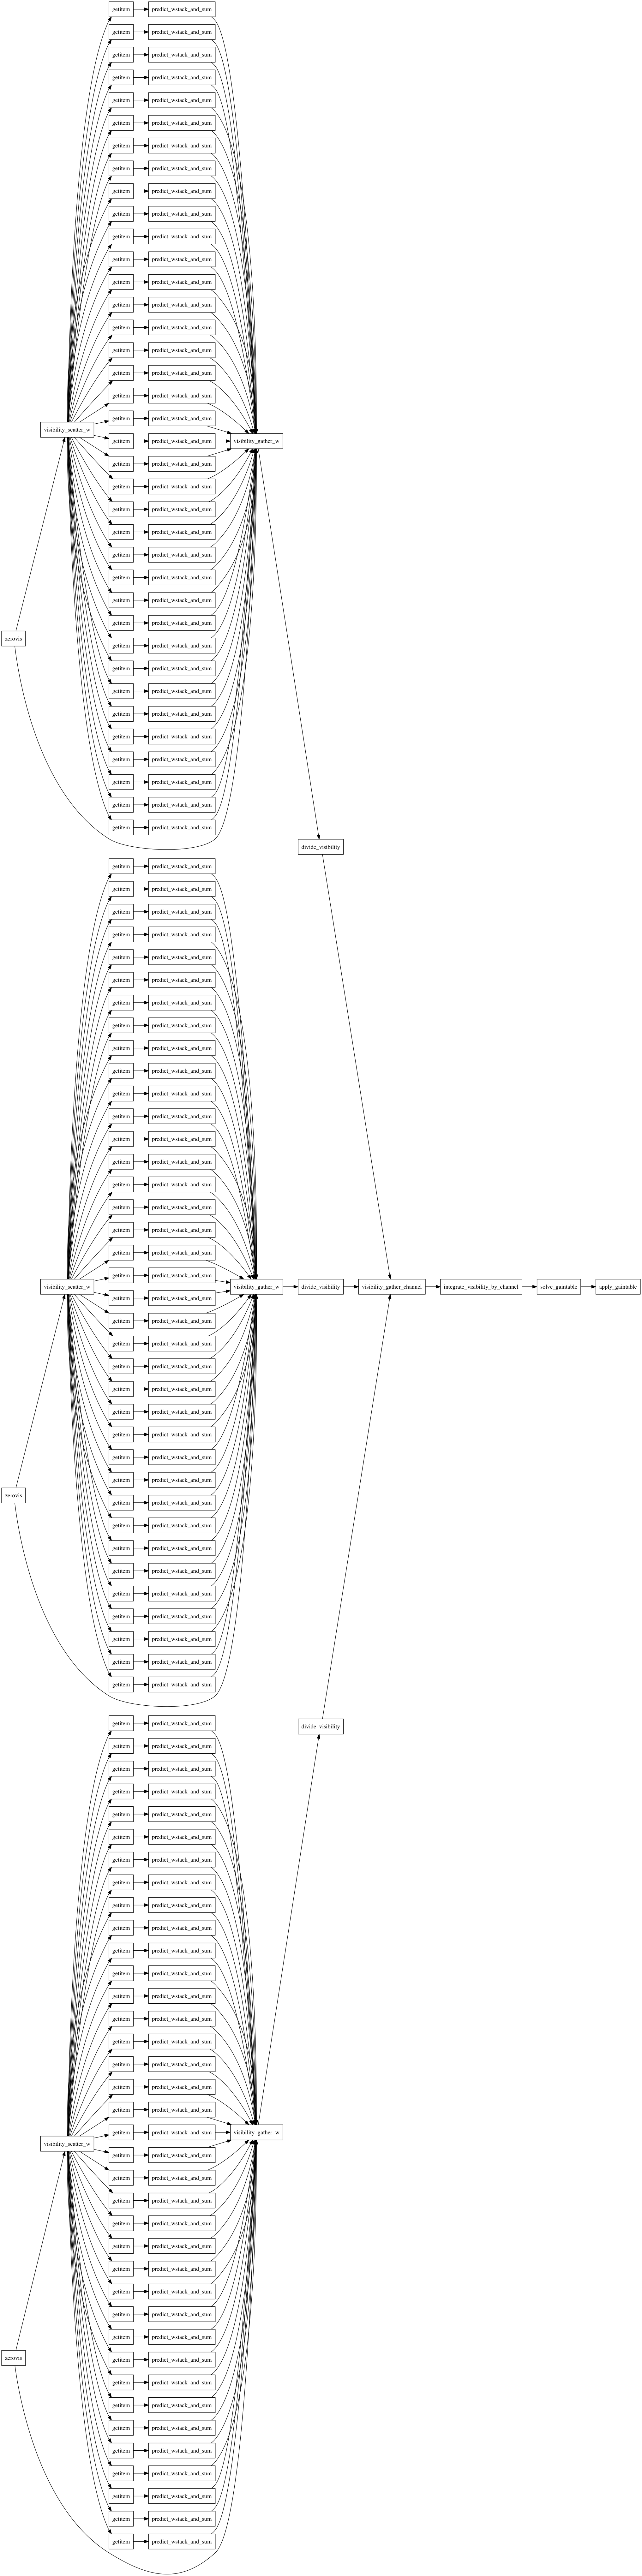

In [9]:
selfcal_vis_graph_list = create_selfcal_graph_list(corrupted_vis_graph_list, LSM_graph,
                                                   c_predict_vis_graph=create_predict_wstack_graph,
                                                   vis_slices=vis_slices,
                                                   global_solution=True)
simple_vis(selfcal_vis_graph_list[0])

The graph for making the dirty image now shows a global synchronisation point. We alleviate this by only sending averaged visibilities to the gather step before averaging over the solution interval, the model visibility is divided out. Only the gaintable is sent back for application.

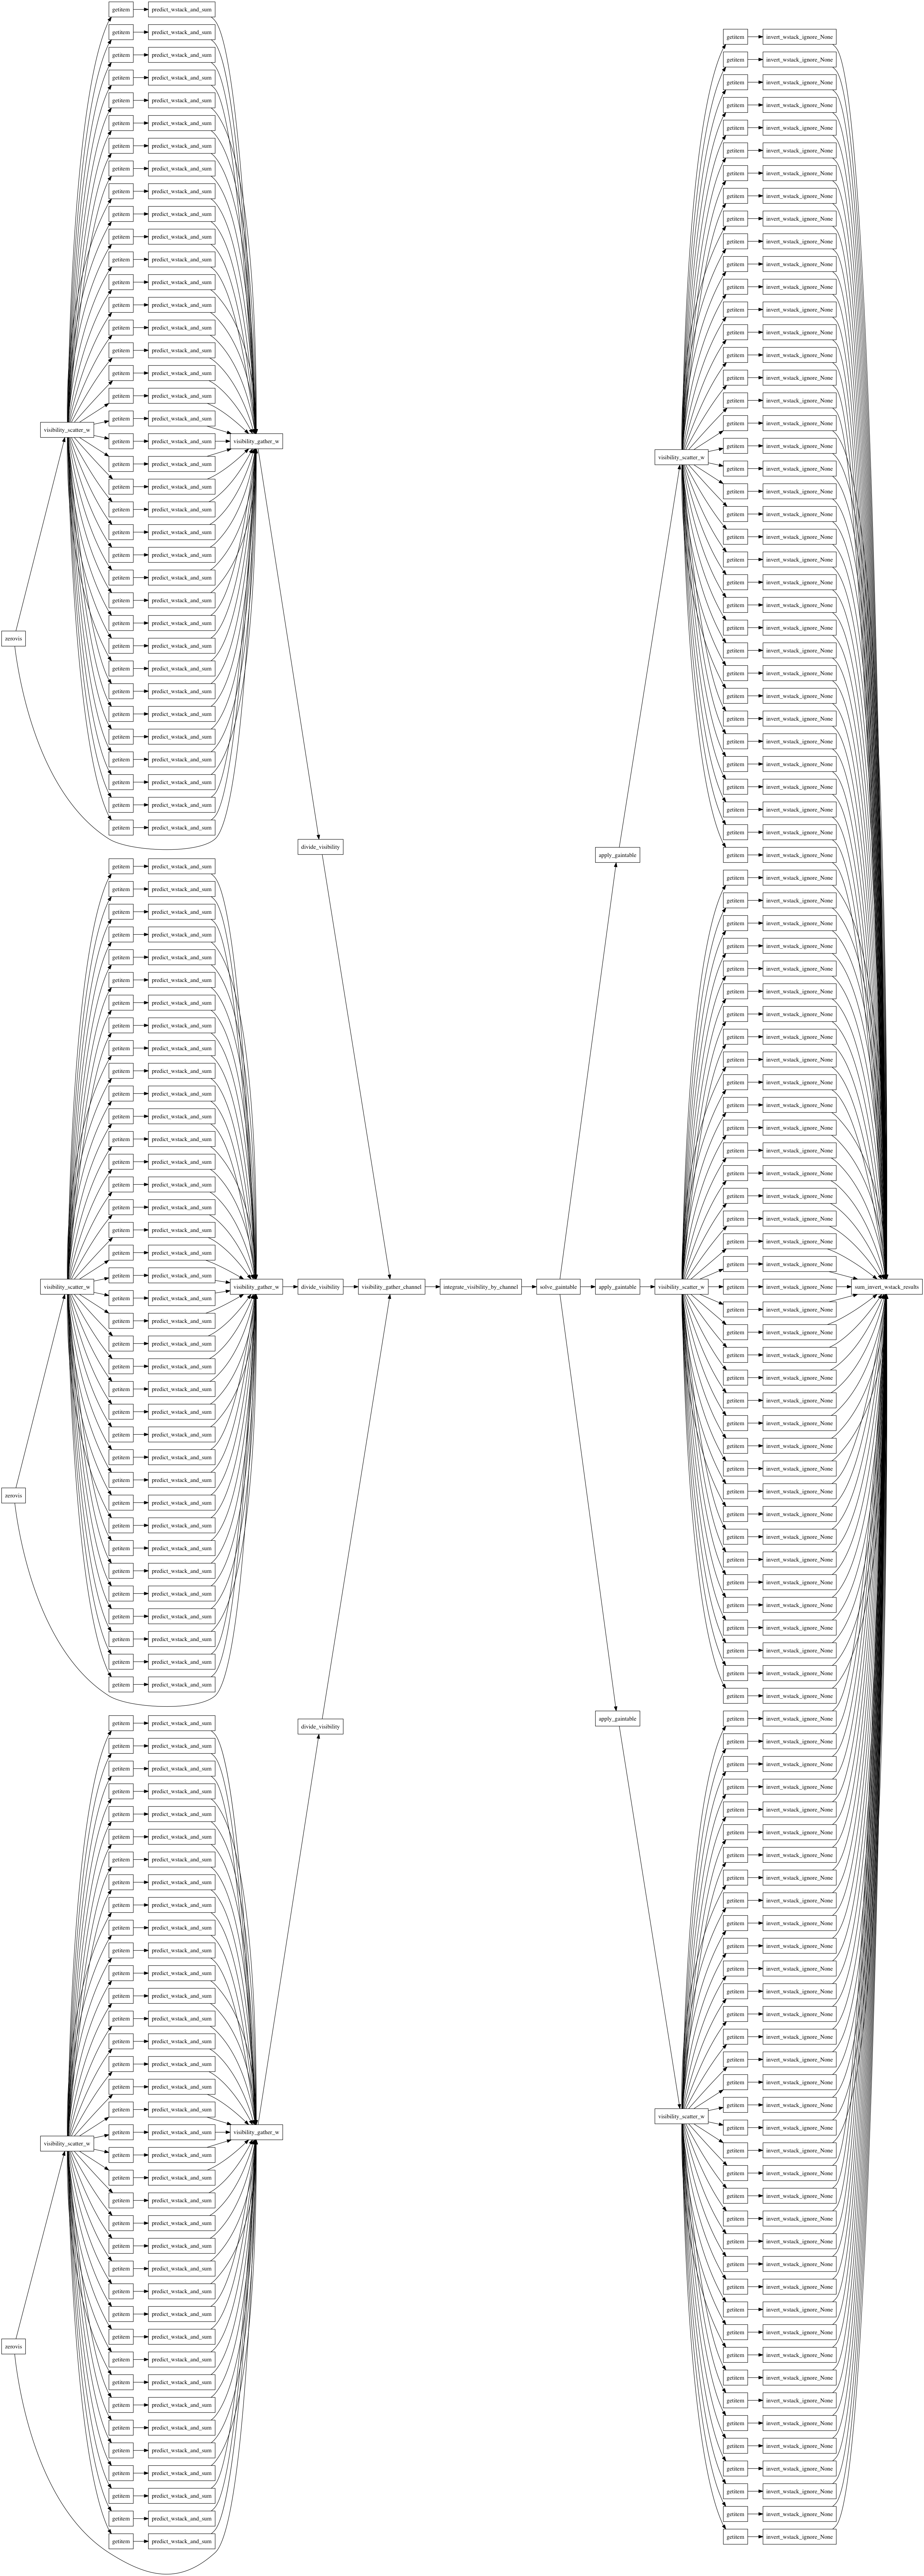

In [10]:
dirty_graph = create_invert_wstack_graph(selfcal_vis_graph_list, LSM_graph, facets=2,
                                         vis_slices=vis_slices, dopsf=False)
simple_vis(dirty_graph)

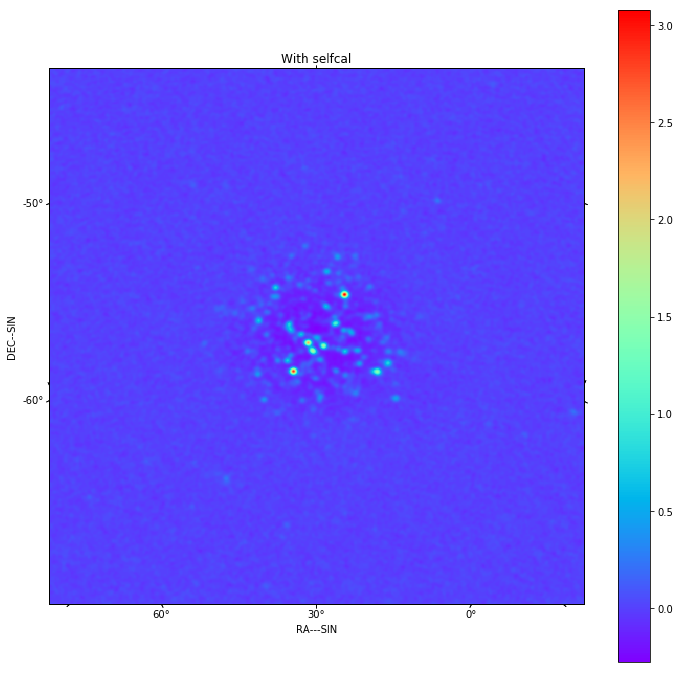

In [11]:
dirty=dirty_graph.compute()
show_image(dirty[0], title='With selfcal')
plt.show()

In [12]:
c.shutdown()

distributed.batched - INFO - Batched Comm Closed: Stream is closed
